# Tutorial 16: Meta-Learning - Learning to Learn

![Status](https://img.shields.io/static/v1.svg?label=Status&message=In%20progress&color=red)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/Meta_Learning.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/Meta_Learning.ipynb)

**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial16)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1GKCVDr5Mz3gLzyEaDLEikfOtaNZhZ6xh?usp=sharing)

In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
from collections import defaultdict
from statistics import mean

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, Omniglot
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial16"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


## Few-shot classification

In [2]:
CIFAR_train_set = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


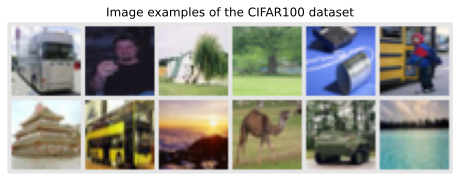

In [3]:
# Visualize some examples
NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Data preprocessing

In [4]:
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)

In [5]:
class ImageDataset(data.Dataset):
    
    def __init__(self, imgs, targets, img_transform=None):
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets
        
    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)
        
        if self.img_transform is not None:
            img = self.img_transform(img)
        
        return img, target
    
    def __len__(self):
        return self.imgs.shape[0]

In [6]:
torch.manual_seed(0)
classes = torch.randperm(100)
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

In [7]:
# Printing validation and test classes
idx_to_class = {val: key for key, val in CIFAR_train_set.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger']
Test classes: ['kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']


In [8]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask],
                        targets=targets[class_mask],
                        **kwargs)

In [9]:
DATA_MEANS = (CIFAR_train_set.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (CIFAR_train_set.data / 255.0).std(axis=(0,1,2))

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

train_set = dataset_from_labels(CIFAR_all_images, CIFAR_all_targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(CIFAR_all_images, CIFAR_all_targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(CIFAR_all_images, CIFAR_all_targets, test_classes, img_transform=test_transform)

### Data sampling

In [10]:
class FewShotBatchSampler(object):
    
    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True):
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
            
        self.batch_size = self.N_way * self.K_shot
        
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.indices_per_class = {}
        self.batches_per_class = {}
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot
        
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        
    def shuffle_data(self):
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        random.shuffle(self.class_list)
        
    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()
        
        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]
            index_batch = []
            for c in class_batch:
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch
        
    def __len__(self):
        return self.iterations

In [11]:
N_WAY = 5
K_SHOT = 4
train_data_loader = data.DataLoader(train_set, 
                                    batch_sampler=FewShotBatchSampler(train_set.targets, 
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT),
                                    num_workers=4)
val_data_loader = data.DataLoader(val_set, 
                                  batch_sampler=FewShotBatchSampler(val_set.targets, 
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False),
                                  num_workers=4)

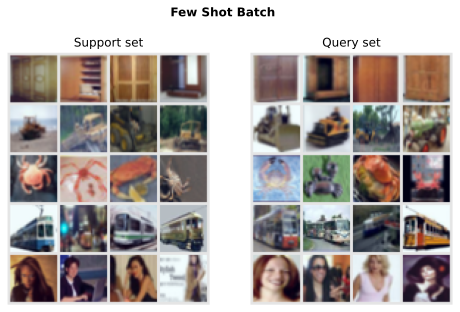

In [12]:
imgs, _ = next(iter(train_data_loader))
support_set, query_set = imgs.chunk(2, dim=0)
support_grid = torchvision.utils.make_grid(support_set, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_set, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8,5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()

In [13]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

## Prototypical networks

In [14]:
def get_resnet(output_size):
    resnet_model = torchvision.models.resnet18()
    resnet_model.fc = nn.Linear(512, output_size)
    return resnet_model

In [15]:
class ProtoNet(pl.LightningModule):
    
    def __init__(self, proto_dim, lr):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = get_resnet(output_size=self.hparams.proto_dim)
        
    def calculate_prototypes(self, features, targets):
        classes, _ = torch.unique(targets).sort()
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        
        return prototypes, classes
    
    def classify_feats(self, prototypes, classes, feats, targets):
        dist = torch.pow(prototypes[None,:] - feats[:,None], 2).sum(dim=2)
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None,:] == targets[:,None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc
        
    def calculate_loss(self, batch, mode):
        imgs, targets = batch
        features = self.model(imgs)
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = self.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)
        
        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,100], gamma=0.1)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")
        
    def validation_step(self, batch, batch_idx):
        _ = self.calculate_loss(batch, mode="val")

In [16]:
def train_model(model_class, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=120,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=1)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = model_class.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_data_loader, val_data_loader)
        model = model_class.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [17]:
model = train_model(ProtoNet, proto_dim=64, lr=1e-3)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at ../saved_models/tutorial16/ProtoNet.ckpt, loading...


In [48]:
@torch.no_grad()
def test_proto_net(model, dataset, classes, data_feats=None, k_shot=4, batch_size=128):
    model = model.to(device)
    model.eval()
    num_classes = len(classes)
    exmps_per_class = dataset.targets.shape[0]//len(classes)
    
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features"): 
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats
    
    # We iterate through the full dataset in two manners. First, to select the k-shot batch. Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification"):
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:
                continue
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)
    
    return accuracies, mean(accuracies), (img_features, img_targets)

In [50]:
data_feats = None
for k in [2, 4, 8, 16, 32]:
    _, mean_acc, data_feats = test_proto_net(model, test_set, test_classes, data_feats=data_feats, k_shot=k)
    print("Accuracy for k=%i: %4.2f%%" % (k, 100.0*mean_acc))


Accuracy for k=2: 33.09%



Accuracy for k=4: 38.50%



Accuracy for k=8: 42.91%



Accuracy for k=16: 46.60%



Accuracy for k=32: 49.45%


## MAML and ProtoMAML

## Experiments

## Conclusion